In [9]:
import os
from skimage import io
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm



# Loading data

In [10]:
#reading train data and generating labels
train_filepath = 'C-NMC_Leukemia/training_data/'
trainpath_array =[]
Y_train = []
all_cells=0
hem_cells=0
for i in ('/all/', '/hem/'):
    for j in range(3):
        dir_path = train_filepath+'fold_'+str(j)+str(i)
        for k in os.listdir(dir_path):
            path= os.path.join(dir_path,k)
            trainpath_array.append(path)
            if i=='/all/':
                Y_train.append(1)
                all_cells=all_cells+1
            else:
                Y_train.append(0)
                hem_cells=hem_cells+1


In [11]:
print('Total number of cancer cells in the train dataset is',all_cells)
print('Total number of normal cells in the train dataset is',hem_cells)

Total number of cancer cells in the train dataset is 7272
Total number of normal cells in the train dataset is 3389


In [31]:
#reading test data 
test_filepath = 'C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/'
testpath_array =[]


for k in os.listdir(test_filepath):
    path= os.path.join(dir_path,k)
    testpath_array.append(path)

print('Total number of cells in the test dataset is',len(testpath_array))

Total number of cells in the test dataset is 2586


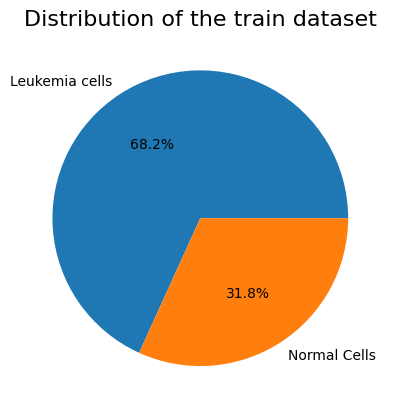

In [12]:
#Display Distribution of the train dataset
plt.pie([all_cells,hem_cells], labels=['Leukemia cells', 'Normal Cells'], autopct='%1.1f%%')
plt.title('Distribution of the train dataset', fontsize=16)
plt.show()

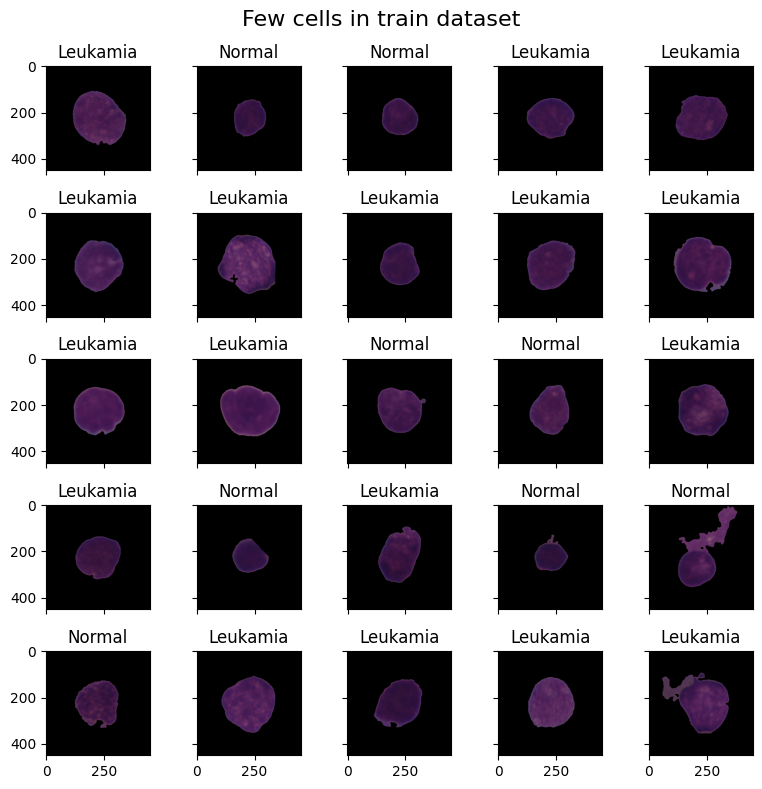

In [15]:
#display random 25 cells in the train dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ran = random.randint(0,len(trainpath_array))
    img= io.imread(trainpath_array[ran])
    ax[i].imshow(img)
    if Y_train[ran]==1:
        ax[i].set_title('Leukamia')
    else:
        ax[i].set_title('Normal')
fig.suptitle('Few cells in train dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [22]:
#explore the size of images
img =io.imread(trainpath_array[0])

print('Shape of a cell image', img.shape)

Shape of a cell image (450, 450, 3)


In [26]:
def resize_img(path_array):
    img_width= 128
    img_height= 128
    img_channels= 3

    img_array= np.zeros((len(path_array), img_height, img_width, img_channels), dtype=np.uint8)
    print('Loading resized cell images')
    for i in tqdm(range(len(path_array))):
        img= io.imread(path_array[i])
        #resize the image
        img= resize(img, (img_height, img_width), mode ='constant', preserve_range=True)
        img_array[i]= img
    return img_array

In [27]:
#resized train data
X_train = resize_img(trainpath_array)

Loading resized cell images


100%|████████████████████████████████████████████████████████████████████████████| 10661/10661 [05:42<00:00, 31.14it/s]


In [28]:
#shape of the X_train
X_train.shape

(10661, 128, 128, 3)

In [29]:
#shuffle data
combined = list(zip(X_train, Y_train))
random.seed(42)
random.shuffle(combined)
X_train, Y_train= zip(*combined)

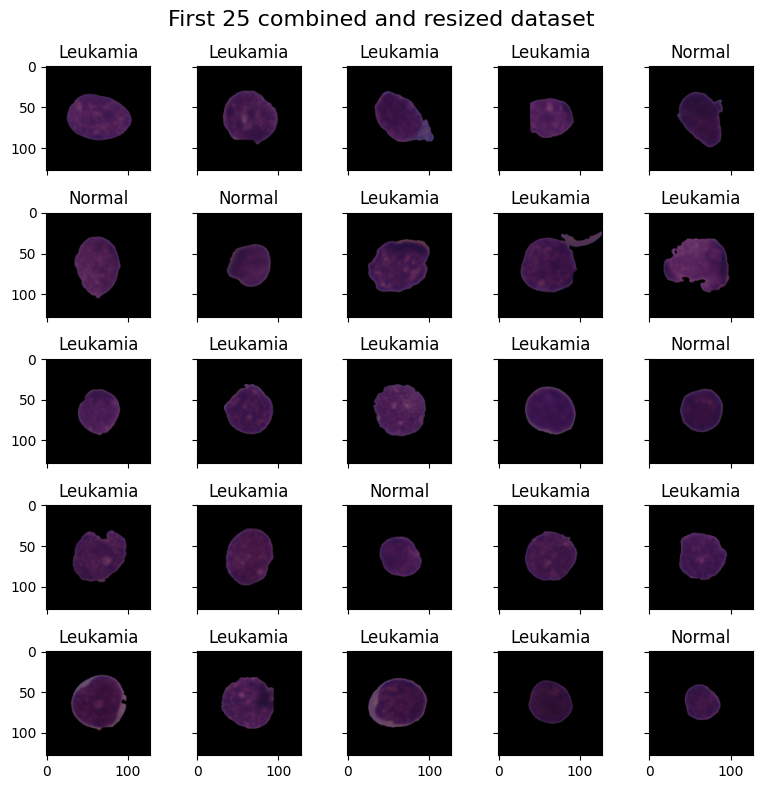

In [30]:
#display resized train dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ax[i].imshow(X_train[i])
    if Y_train[i]==1:
        ax[i].set_title('Leukamia')
    else:
        ax[i].set_title('Normal')
fig.suptitle('First 25 combined and resized dataset', fontsize=16)
plt.tight_layout()
plt.show()